In [1]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import io
from ase.optimize import BFGS, LBFGS, FIRE, LBFGSLineSearch
from ase.visualize import view
from ase.io import Trajectory
from ase import Atoms
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


macemp0 = mace_mp(dispersion=True, default_dtype="float64", model="medium")
macemp = mace_mp(dispersion=True, default_dtype="float64")

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


In [28]:
graphene_atoms = io.read("structures/graphene_atoms.xyz")
mxene_relaxed_mace = io.read("structures/mxene_relaxed_mace.xyz")
mxene_relaxed_omat = io.read("structures/mxene_relaxed_omat.xyz")

mxene_unit_mace = io.read("structures/relax_mxene_unit_mace.xyz")
mxene_unit_omat = io.read("structures/relax_mxene_unit_omat.xyz")

### MXene thickness

In [3]:
def calculate_thickness(atoms):
    top_O_z = [atom.position[2] for atom in atoms if atom.tag == 3]
    bottom_O_z = [atom.position[2] for atom in atoms if atom.tag == 1]
    
    thickness = np.mean(top_O_z) - np.mean(bottom_O_z)
    return thickness

In [4]:
calculate_thickness(mxene_relaxed_mace)

4.463190900000001

In [5]:
calculate_thickness(mxene_relaxed_omat)

4.46016048

### Bond distances in MXene

In [16]:
top_o = [atom for atom in mxene_relaxed_mace if atom.tag == 3]
bottom_o = [atom for atom in mxene_relaxed_mace if atom.tag == 1]
mxene_c = [atom for atom in mxene_relaxed_mace if atom.symbol == "C"]
bottom_ti = [atom for atom in mxene_relaxed_mace if atom.symbol == "Ti" and atom.position[2] < np.mean([atom.position[2] for atom in mxene_relaxed_mace if atom.symbol == "C"])]
top_ti = [atom for atom in mxene_relaxed_mace if atom.symbol == "Ti" and atom.position[2] > np.mean([atom.position[2] for atom in mxene_relaxed_mace if atom.symbol == "C"])]

In [27]:
from ase.neighborlist import neighbor_list

cutoffs = {"Ti-O": 2.5, "Ti-C": 2.5, "Ti-Ti": 3.5}

def compute_bonded_distances(atoms, sym1, sym2, cutoff):
    """Finds and computes bonded distances between sym1 and sym2 atoms."""
    indices1 = [atom.index for atom in atoms if atom.symbol == sym1]
    indices2 = [atom.index for atom in atoms if atom.symbol == sym2]

    i_list, j_list, distances = neighbor_list("ijd", atoms, cutoff)

    bonded_distances = [
        d for i, j, d in zip(i_list, j_list, distances)
        if (i in indices1 and j in indices2) or (i in indices2 and j in indices1)
    ]
    return bonded_distances

ti_o_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "O", cutoffs["Ti-O"])
ti_c_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "C", cutoffs["Ti-C"])
ti_ti_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "Ti", cutoffs["Ti-Ti"])


print(f"Bonded Ti-O Distances:{np.mean(ti_o_bonds)}, {np.std(ti_o_bonds)}")
print(f"Bonded Ti-C Distances:{np.mean(ti_c_bonds)}, {np.std(ti_c_bonds)}")
print(f"Bonded Ti-Ti Distances:{np.mean(ti_ti_bonds)}, {np.std(ti_ti_bonds)}")

Bonded Ti-O Distances:1.9764461583387696, 2.494785538872408e-09
Bonded Ti-C Distances:2.186571924739105, 2.543624509981871e-09
Bonded Ti-Ti Distances:3.07110984351616, 0.05813809824758935


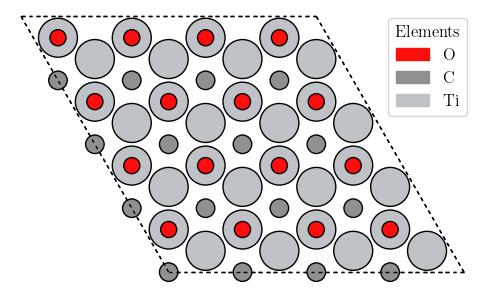

In [54]:
from ase.visualize.plot import plot_atoms
import matplotlib.patches as mpatches
from ase.data.colors import jmol_colors
from ase.data import atomic_numbers


unique_elements = set(mxene_relaxed_omat.get_chemical_symbols())  # Unique elements in the structure
element_colors = {el: jmol_colors[atomic_numbers[el]] for el in unique_elements}
                  
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the atoms in 2D
plot_atoms(mxene_relaxed_omat, ax, radii=0.5, rotation=('0x, 0y, 0z'))  # Adjust rotation as needed

legend_patches = [mpatches.Patch(color=color, label=el) for el, color in element_colors.items()]
ax.legend(handles=legend_patches, loc="upper right", title="Elements")

plt.axis("off")
plt.show()


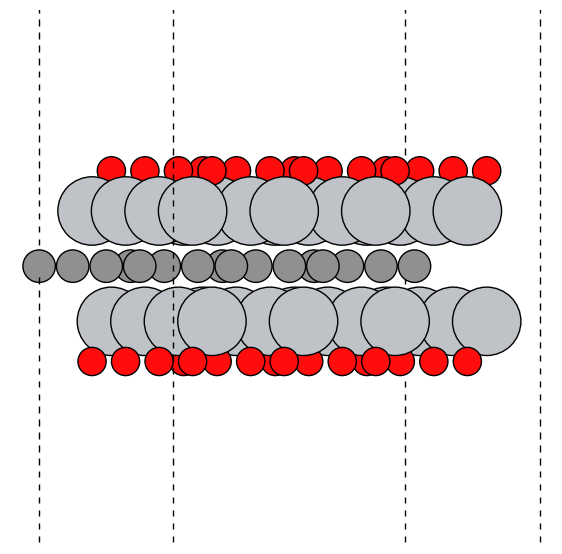

In [ ]:
from matplotlib.patches import FancyArrow, FancyArrowPatch

fig, ax = plt.subplots(figsize=(7, 7))

# Plot the atoms in 2D
plot_atoms(mxene_relaxed_omat, ax, radii=0.5, rotation=('90x, 45y, 0z'))  # Adjust rotation as needed


plt.axis("off")
plt.ylim(24.5, 37)

plt.show()

In [117]:
mxene_relaxed_omat.positions

array([[ 0.        , -0.        , 10.        ],
       [-0.        ,  1.74937132,  8.70931758],
       [ 1.515     ,  0.87468566, 11.29068242],
       [-0.        ,  1.74937132, 12.23008024],
       [ 1.515     ,  0.87468566,  7.76991976],
       [-1.515     ,  2.62405697, 10.        ],
       [-1.515     ,  4.37342829,  8.70931758],
       [ 0.        ,  3.49874263, 11.29068242],
       [-1.515     ,  4.37342829, 12.23008024],
       [ 0.        ,  3.49874263,  7.76991976],
       [-3.03      ,  5.24811395, 10.        ],
       [-3.03      ,  6.99748526,  8.70931758],
       [-1.515     ,  6.1227996 , 11.29068242],
       [-3.03      ,  6.99748526, 12.23008024],
       [-1.515     ,  6.1227996 ,  7.76991976],
       [-4.545     ,  7.87217092, 10.        ],
       [-4.545     ,  9.62154224,  8.70931758],
       [-3.03      ,  8.74685658, 11.29068242],
       [-4.545     ,  9.62154224, 12.23008024],
       [-3.03      ,  8.74685658,  7.76991976],
       [ 3.03      ,  0.        , 10.   

In [122]:
bottom_z_mean, top_z_mean

(7.76991976, 12.23008024)

In [124]:
# max position in mxene
max_pos = np.max(mxene_relaxed_omat.positions, axis=0)
max_pos

array([10.605     ,  9.62154224, 12.23008024])

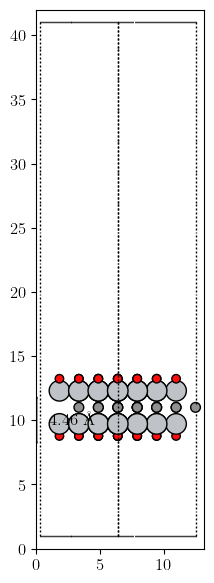

In [121]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import numpy as np
from matplotlib.patches import FancyArrow, FancyArrowPatch

# Define z-coordinates for the top and bottom oxygen layers
top_O_z = [atom.position[2] for atom in mxene_relaxed_omat if atom.tag == 3]
bottom_O_z = [atom.position[2] for atom in mxene_relaxed_omat if atom.tag == 1]

# Compute mean positions to determine arrow placement
top_z_mean = np.mean(top_O_z)
bottom_z_mean = np.mean(bottom_O_z)

# Define x-position for the arrow (somewhere visible, e.g., center of the plot)
x_pos = 0  # Adjust if necessary

# Create figure
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the atoms
plot_atoms(mxene_relaxed_omat, ax, radii=0.5, rotation=('90x, 60y, 180z'))

# Draw double-headed arrow for thickness
arrow = FancyArrowPatch((x_pos, bottom_z_mean), (x_pos, top_z_mean), 
                        arrowstyle='<->', color='black', lw=2)

ax.add_patch(arrow)

# Optional: Add text label for thickness
thickness = top_z_mean - bottom_z_mean
ax.text(x_pos + 1, (top_z_mean + bottom_z_mean) / 2, f'{thickness:.2f} Å', 
        fontsize=12, verticalalignment='center')

# Adjust plot settings
#plt.axis("off")
#plt.ylim(24.5, 37)
plt.show()


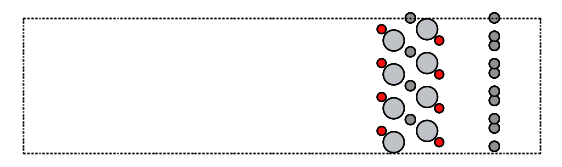

In [111]:
fig, ax = plt.subplots(figsize=(7, 7))

total_atoms = mxene_relaxed_omat + graphene_atoms

# Plot the atoms in 2D
plot_atoms(total_atoms, ax, radii=0.5, rotation=('90x, 30y, -90z'))  # Adjust rotation as needed


plt.axis("off")
#plt.ylim(25, 40)
plt.show()